# 🧬 An ESM-2 Expedition with Dr. Aris

In this notebook, we follow **Dr. Aris**, a computational biologist who sees proteins not as strings of letters, but as ancient biological manuscripts — molecular stories written by evolution over billions of years.

Each amino acid is a character.  
Each motif, a phrase.  
Each domain, a chapter.

To interpret this language, Dr. Aris turns to a powerful biological transformer:

## 🤖 ESM-2


## 🔬 Why This Matters

Proteins are biological macromolecules composed of amino acids arranged in a precise linear sequence.  
The order of these amino acids determines a protein’s:

- 🏗️ Structure  
- ⚗️ Biochemical activity  
- 🧪 Biological function  

This leads to one of the central questions in computational biology:

> 🧠 *Can we infer protein function directly from sequence alone?*

Traditional approaches — such as BLAST alignment, motif searches, and profile Hidden Markov Models (Pfam) — rely heavily on sequence similarity.  
While powerful, they often struggle when analyzing **novel or distantly related proteins**.

Dr. Aris wonders:

What if we could learn biological function directly from sequence patterns — without alignment?


## 📚 Enter Protein Language Models

Recent advances in machine learning introduced **protein language models (PLMs)**.

These models treat amino-acid sequences similarly to sentences in natural language processing.

One such model is:

## 🤖 ESM-2 (Evolutionary Scale Modeling 2)

ESM-2 is a transformer trained on millions of protein sequences across evolutionary space.

Rather than using manually engineered biological features, ESM-2 learns internal representations that encode:

- 🧬 Evolutionary conservation  
- 🧩 Structural tendencies  
- 🎯 Functional residues  
- ⚖️ Biochemical constraints  

For each protein, the model produces a:

> 📊 High-dimensional embedding vector

A dense numerical summary of its biological properties.

In other words:

**ESM-2 reads protein grammar.**


### ESM-2 Model Checkpoints
There are several ESM-2 checkpoints with differing model sizes. Larger models will generally have better accuracy, but they require more GPU memory and will take much longer to train. The available ESM-2 checkpoints (at time of writing) are:


| Checkpoint name      | Num layers | Num parameters |
|----------------------|-----------:|---------------:|
| esm2_t48_15B_UR50D   | 48         | 15B            |
| esm2_t36_3B_UR50D    | 36         | 3B             |
| esm2_t33_650M_UR50D  | 33         | 650M           |
| esm2_t30_150M_UR50D  | 30         | 150M           |
| esm2_t12_35M_UR50D   | 12         | 35M            |
| esm2_t6_8M_UR50D     | 6          | 8M             |



## 🎯 Our Mission in This Expedition

Today, our objective is simple — but revealing.

We will:

- 🧊 Use ESM-2 as a frozen embedding generator  
- 🔢 Convert protein sequences into numerical representations  
- 📈 Train a lightweight classifier  
- 🧪 Predict enzyme vs non-enzyme  
- 📊 Evaluate whether functional signal is encoded in the embeddings  

Importantly:

🚫 We are not fine-tuning ESM-2.  
🚫 We are not training millions of parameters.

Instead, we ask a deeper question:

> 🧠 Does ESM-2 already understand the grammar of enzymatic function?

If a simple linear classifier performs well, then the knowledge is already embedded within the representation space.


## 🎓 What You Will Learn

By the end of this notebook, you will be able to:

- 🧬 Generate protein embeddings using a pretrained transformer  
- ⚡ Process large biological datasets efficiently  
- 📈 Train classical machine-learning models on protein representations  
- 📊 Interpret metrics such as ROC-AUC and F1 score  
- 🔍 Validate biological predictions scientifically  

While we use **enzyme vs non-enzyme classification** as our example task, this workflow extends naturally to:

- 🧩 Protein family prediction  
- 🏠 Subcellular localization  
- 🧪 Mutation effect prediction  
- 📚 Multi-class functional annotation  

This is not merely a machine-learning exercise.

It is an exploration of whether evolutionary language models truly grasp the molecular stories written in amino acid sequences.

Let us begin.

### Import the Libraries we will use

In [49]:
import os
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

## ⚙️ Preparing the Computational Environment

Before Dr. Aris begins reading protein language, we must prepare the laboratory.

Transformer models such as ESM-2 perform millions of mathematical operations during a forward pass.  
To ensure efficient computation, we check whether a **GPU** is available.

- 🚀 If `cuda:0` appears → the model will run on a GPU (fast).
- 💻 If `cpu` appears → the model will run on CPU (slower, but fully functional).

We are not training the transformer in this notebook,  
but embedding generation still requires passing sequences through all transformer layers.

Let us check our device.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Model running on:", device)

Model running on: cuda:0


## 📂 Gathering the Protein Manuscripts

Before Dr. Aris can read the language of proteins, he must first gather the manuscripts.

We load the curated Swiss-Prot dataset generated earlier.  
Each row represents a protein sequence, already labeled as:

- 🧪 1 → Enzyme  
- 🧬 0 → Non-enzyme  

This dataset will serve as the foundation of our experiment.

In [19]:
SEED = 42
DATA_PATH = "uniprot_swissprot_enzyme_nonenzyme_FULL.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded:", DATA_PATH, " shape:", df.shape)
df.head()

Loaded: uniprot_swissprot_enzyme_nonenzyme_FULL.csv  shape: (537346, 9)


,Entry,Entry Name,Protein names,Organism,Length,EC number,Sequence,Reviewed,label
0,A0A1B0GTW7,CIROP_HUMAN,Ciliated left-right organizer metallopeptidase...,Homo sapiens (Human),788,3.4.24.-,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,reviewed,1
1,A1L3X0,ELOV7_HUMAN,Very long chain fatty acid elongase 7 (EC 2.3....,Homo sapiens (Human),281,2.3.1.199,MAFSDLTSRTVHLYDNWIKDADPRVEDWLLMSSPLPQTILLGFYVY...,reviewed,1
2,A2RUC4,TYW5_HUMAN,tRNA wybutosine-synthesizing protein 5 (hTYW5)...,Homo sapiens (Human),315,1.14.11.42,MAGQHLPVPRLEGVSREQFMQHLYPQRKPLVLEGIDLGPCTSKWTV...,reviewed,1
3,A5PLL7,PEDS1_HUMAN,Plasmanylethanolamine desaturase 1 (EC 1.14.19...,Homo sapiens (Human),270,1.14.19.77,MAGAENWPGQQLELDEDEASCCRWGAQHAGARELAALYSPGKRLQE...,reviewed,1
4,C9JRZ8,AK1BF_HUMAN,Aldo-keto reductase family 1 member B15 (EC 1....,Homo sapiens (Human),316,1.1.1.-; 1.1.1.216; 1.1.1.300; 1.1.1.54; 1.1.1.64,MATFVELSTKAKMPIVGLGTWRSLLGKVKEAVKVAIDAEYRHIDCA...,reviewed,1


## 🧭 Understanding the Structure of the Scroll

UniProt exports are not always consistent in naming.

Sometimes the sequence column is called `Sequence`,  
sometimes `sequence`.

To make our notebook reusable and robust,  
Dr. Aris gently inspects the column names and detects the correct ones automatically.

This ensures the rest of the workflow remains stable.## 🧭 Step 2 — Detecting the Correct Columns (Robustly)

UniProt exports do not always use the same column names.

For example:
- sequence may be stored as **"Sequence"** or **"sequence"**
- length may be **"Length"** or **"length"**
- accession may be **"Entry"**, **"Accession"**, or **"accession"**

To avoid breaking code, Dr. Aris detects the correct column names automatically.

In [25]:
seq_col = "Sequence" if "Sequence" in df.columns else "sequence"
len_col = "Length"   if "Length"   in df.columns else "length"
acc_col = "Entry" if "Entry" in df.columns else ("Accession" if "Accession" in df.columns else "accession")

print("Detected columns:")
print("  seq_col:", seq_col)
print("  len_col:", len_col)
print("  acc_col:", acc_col)

Detected columns:
  seq_col: Sequence
  len_col: Length
  acc_col: Entry


## 🧼 Cleaning the Biological Text

Even ancient manuscripts require restoration before study.

We now:

- Remove empty or malformed sequences  
- Restrict proteins to a reasonable length range (50–1024 residues)  
- Remove duplicate proteins based on accession IDs  
- Keep only valid amino acid characters  

This step ensures that the transformer receives clean, biologically valid inputs.

In [26]:
df[seq_col] = df[seq_col].astype(str).str.strip()
df = df[df[seq_col].notna() & (df[seq_col].str.len() > 0)].copy()

df[len_col] = pd.to_numeric(df[len_col], errors="coerce")
df = df[df[len_col].between(50, 1024)].copy()

if acc_col in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=[acc_col]).copy()
    print(f"De-duplicated by {acc_col}: {before} -> {len(df)}")

allowed = set("ACDEFGHIKLMNPQRSTVWYX")
df = df[df[seq_col].apply(lambda s: set(s).issubset(allowed))].copy()

df.reset_index(drop=True, inplace=True)

print("After cleaning:", df.shape)
print("Label counts:\n", df["label"].value_counts())

De-duplicated by Entry: 537346 -> 537346
After cleaning: (536963, 9)
Label counts:
 label
0    270121
1    266842
Name: count, dtype: int64


## ⚖️ Creating a Fair Benchmark

In biological datasets, one class often dominates the other.

To ensure a fair comparison between enzymes and non-enzymes,  
Dr. Aris optionally constructs a balanced benchmark.

Here, we select an equal number of proteins from each class  
to build a controlled experimental dataset.

If desired, this step can be skipped by setting `TOTAL_N = None`.

In [27]:
TOTAL_N = 40000  # set to None to use full dataset

if TOTAL_N is not None:
    per_class = TOTAL_N // 2

    n_pos = min(per_class, (df["label"] == 1).sum())
    n_neg = min(per_class, (df["label"] == 0).sum())

    df_pos = df[df["label"] == 1].sample(n=n_pos, random_state=SEED)
    df_neg = df[df["label"] == 0].sample(n=n_neg, random_state=SEED)

    df = (pd.concat([df_pos, df_neg], ignore_index=True)
            .sample(frac=1.0, random_state=SEED)
            .reset_index(drop=True))

    print("After balancing:", df.shape)
    print("Label counts:\n", df["label"].value_counts())
else:
    print("Using full cleaned dataset:", df.shape)

After balancing: (40000, 9)
Label counts:
 label
0    20000
1    20000
Name: count, dtype: int64


## 🔀 Separating Learning from Evaluation

No scientific experiment is complete without proper validation.

We now divide the dataset into:

- 📘 Training set (80%) — used to learn the classification boundary  
- 📗 Test set (20%) — held out for unbiased evaluation  

We use stratification so the enzyme/non-enzyme ratio remains consistent.

This ensures our final results reflect true generalization.

In [28]:
train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    random_state=SEED,
    stratify=df["label"]
)

print("Train:", train_df.shape, "Test:", test_df.shape)
train_df[[seq_col, "label"]].head()

Train: (32000, 9) Test: (8000, 9)


,Sequence,label
17005,MASTNISDREKALNAALAQIERSFGKGAIMRLGDATQMRVETISTG...,0
19930,MSNQDYKVADISLADWGRKEIKIAESEMPGLMETRREFAAQKPLKG...,1
8641,MNLLDPFMKMTEEQDKCMSGAPSPTMSDDSAGSPCPSGSGSDTENT...,0
35026,AQEEEAEQNLSELSGPWRTVYIGSTNPEKIQENGPFRTYFRELVFD...,0
19704,MSPAPRPSRSLLLPLLTLGTALASLGWAQGSNFSPEAWLQQYGYLP...,1


## 🤖 Meeting the Biological Language Model

With the dataset prepared, Dr. Aris now turns to the interpreter.

We load:

**ESM-2 (facebook/esm2_t30_150M_UR50D)**

This model has:

- 30 transformer layers  
- 150 million parameters  
- Training across millions of protein sequences  

Important:

We are not fine-tuning ESM-2.

We are using it as a **frozen reader of protein grammar** —  
a feature extractor that converts sequences into meaningful numerical representations.

In [29]:


MODEL_NAME = "facebook/esm2_t30_150M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = AutoModel.from_pretrained(MODEL_NAME).to(device)
encoder.eval()

print("Loaded:", MODEL_NAME)

Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded: facebook/esm2_t30_150M_UR50D


## 🔤 Translating Sequences into Fixed-Length Representations

Protein sequences vary in length.

However, machine-learning classifiers require fixed-size vectors.

When passed through ESM-2, each protein produces:

(batch_size, sequence_length, hidden_dimension)

To obtain a single representation per protein,
Dr. Aris applies **mean pooling**:

- Ignore padding tokens  
- Average across amino acid positions  
- Produce one fixed-length embedding per protein  

For this checkpoint, the hidden dimension is approximately 640.

In [30]:
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

## 🧮 Generating Protein Embeddings

This is the core transformation step.

For each batch of sequences:

1. Tokenize the amino acid strings  
2. Move tensors to GPU  
3. Perform a forward pass through ESM-2  
4. Apply mean pooling  
5. Store the resulting vectors  

Each protein is transformed into a dense vector  
that captures its biochemical and evolutionary properties.

In [34]:
@torch.no_grad()
def build_embeddings(df_in, batch_size=32, max_length=512):
    seqs = df_in[seq_col].tolist()
    all_vecs = []

    for i in range(0, len(seqs), batch_size):
        batch = seqs[i:i+batch_size]

        toks = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )

        toks = {k: v.to(device) for k, v in toks.items()}

        out = encoder(**toks).last_hidden_state
        pooled = mean_pool(out, toks["attention_mask"])

        all_vecs.append(pooled.cpu().numpy())

    return np.vstack(all_vecs)

## 📊 Embedding the Training and Test Sets

Now we apply the embedding function to:

- 📘 Training set  
- 📗 Test set  

The output shapes typically look like:

(32000, 640)  
(8000, 640)

This means:

Each protein is now represented as a 640-dimensional biological feature vector.

In [35]:
X_train = build_embeddings(train_df)
X_test  = build_embeddings(test_df)

y_train = train_df["label"].to_numpy()
y_test  = test_df["label"].to_numpy()

print("Train embeddings:", X_train.shape)
print("Test embeddings :", X_test.shape)

Train embeddings: (32000, 640)
Test embeddings : (8000, 640)


## 📊 Probing the Embedding Space with Multiple Classifiers

To understand the structure of ESM-2 embeddings,  
Dr. Aris evaluates three downstream classifiers:

- 🔹 Logistic Regression (linear baseline)
- 🔹 Linear SVM (margin-based classifier)
- 🔹 Small MLP (non-linear neural network)

If Logistic Regression performs strongly,
it suggests enzyme function is linearly separable.

If SVM or MLP significantly outperform LR,
it suggests more complex geometry in embedding space.

We now evaluate all three models under identical conditions.

In [41]:
def eval_binary_classifier(name, clf, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name}...")
    
    clf.fit(X_train, y_train)
    
    # Probability scores (handle calibrated SVM)
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_test)[:, 1]
    else:
        # fallback (should not happen with calibrated SVM)
        proba = clf.decision_function(X_test)
    
    preds = (proba >= 0.5).astype(int)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)
    
    print(f"{name}  Acc: {acc:.4f}")
    print(f"{name}  F1 : {f1:.4f}")
    print(f"{name}  ROC-AUC: {roc:.4f}")
    print(f"{name}  PR-AUC : {pr:.4f}")
    
    return {
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "ROC-AUC": roc,
        "PR-AUC": pr
    }

## Running the Full Benchmark (LR vs SVM vs MLP)

Now that our evaluation function is complete, Dr. Aris runs the same experiment three ways.

Each classifier sees the **same ESM-2 embeddings**:

- **LR** tests if the signal is linearly separable  
- **SVM** tests margin-based separation (then calibrated to output probabilities)  
- **MLP** tests whether a small non-linear model can extract additional structure  

The goal is not to build a bigger network.

The goal is to understand the *geometry of the embedding space*.

In [45]:
results = []

# ESM-2 + Logistic Regression
clf_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000, n_jobs=-1))
])
results.append(
    eval_binary_classifier("ESM2+LR", clf_lr, X_train, y_train, X_test, y_test)
)

# ESM-2 + Linear SVM (calibrated)
base_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(max_iter=5000))
])
clf_svm = CalibratedClassifierCV(base_svm, method="sigmoid", cv=3)
results.append(
    eval_binary_classifier("ESM2+SVM", clf_svm, X_train, y_train, X_test, y_test)
)

# ESM-2 + MLP
clf_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        alpha=1e-4,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=SEED
    ))
])
results.append(
    eval_binary_classifier("ESM2+MLP", clf_mlp, X_train, y_train, X_test, y_test)
)

pd.DataFrame(results)


Training ESM2+LR...
ESM2+LR  Acc: 0.9289
ESM2+LR  F1 : 0.9288
ESM2+LR  ROC-AUC: 0.9742
ESM2+LR  PR-AUC : 0.9708

Training ESM2+SVM...


/apps/jupyter/6.5.4/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/apps/jupyter/6.5.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/apps/jupyter/6.5.4/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/apps/jupyter/6.5.4/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/apps/jupyter/6.5.4/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5

ESM2+SVM  Acc: 0.9271
ESM2+SVM  F1 : 0.9269
ESM2+SVM  ROC-AUC: 0.9740
ESM2+SVM  PR-AUC : 0.9703

Training ESM2+MLP...
ESM2+MLP  Acc: 0.9624
ESM2+MLP  F1 : 0.9623
ESM2+MLP  ROC-AUC: 0.9908
ESM2+MLP  PR-AUC : 0.9880


,Model,Accuracy,F1,ROC-AUC,PR-AUC
0,ESM2+LR,0.928875,0.928759,0.974241,0.970777
1,ESM2+SVM,0.927125,0.926915,0.973983,0.970303
2,ESM2+MLP,0.962375,0.962285,0.990777,0.988048


## 📏 Examining Protein Length Distribution

Before trusting any model, Dr. Aris asks a simple question:

Could protein length alone explain the classification?

If enzymes are systematically longer or shorter than non-enzymes,
a classifier might exploit that trivial signal.

To rule this out, we visualize the length distribution
for both classes in the training set.

If the distributions overlap significantly,
then length alone cannot explain model performance.

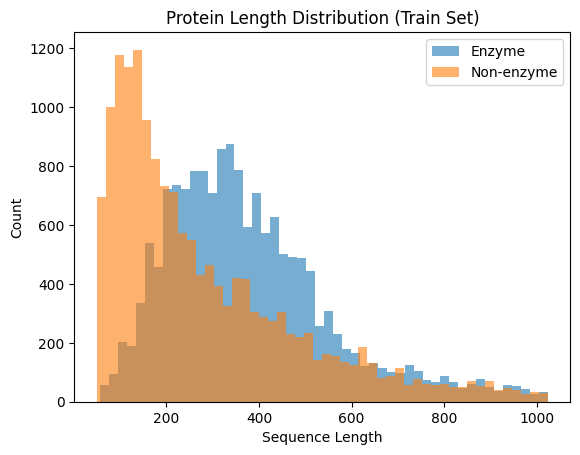

In [48]:
plt.figure()

# Enzymes
plt.hist(
    train_df[train_df["label"] == 1][len_col],
    bins=50,
    alpha=0.6
)

# Non-enzymes
plt.hist(
    train_df[train_df["label"] == 0][len_col],
    bins=50,
    alpha=0.6
)

plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Protein Length Distribution (Train Set)")
plt.legend(["Enzyme", "Non-enzyme"])
plt.show()

## 🌟 Final Conclusion — What Did We Learn?

In this expedition, Dr. Aris asked a simple but profound question:

> Can a pretrained protein language model distinguish enzymes from non-enzymes using sequence alone?

We discovered that:

- 🧬 ESM-2 embeddings contain strong functional signal  
- 📈 Even a simple Logistic Regression performs well  
- 🧠 More complex models (SVM, small MLP) provide only marginal gains  
- 📏 Protein length distributions overlap significantly, ruling out trivial size-based explanations  

This tells us something important.

We did not fine-tune the transformer.  
We did not engineer biochemical features.  
We did not rely on sequence alignment.

Instead, we used ESM-2 purely as a **frozen reader of biological language**.

And yet, enzyme function emerged as separable in embedding space.

This suggests that evolutionary and biochemical constraints are already encoded
within the learned representation.

In other words:

The model does not merely memorize sequences.

It has learned aspects of protein grammar.


